# Course project

In [2]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

In [3]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [4]:
# input
TRAIN_DATASET_PATH = 'D:/study/DataScience/Python/CourseWork/course_project_train.csv'
TEST_DATASET_PATH = 'D:/study/DataScience/Python/CourseWork/course_project_test.csv'

#output
PREP_DATASET_PATH = 'D:/study/DataScience/Python/CourseWork/project_preprocessing.csv'
TRAIN_FULL_PATH = 'D:/study/DataScience/Python/CourseWork/project_train_full.csv'
TRAIN_PART_PATH = 'D:/study/DataScience/Python/CourseWork/project_train_split.csv'
VALID_PART_PATH = 'D:/study/DataScience/Python/CourseWork/project_valid.csv'
PREP_TEST = 'D:/study/DataScience/Python/CourseWork/project_prep_test.csv'

## Обзор данных

In [5]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

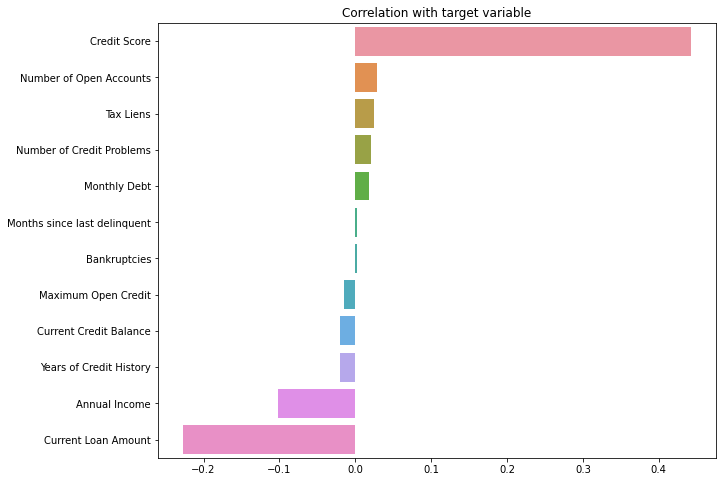

In [7]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Особое внимание при предобработке данных стоит обратить на 'Credit score', 'Annual Income' и 'Current Loan Amount', так как они наиболее сильно коррелируют с целевой переменной

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


## Предобработка данных

### Обработка пропусков 

In [10]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

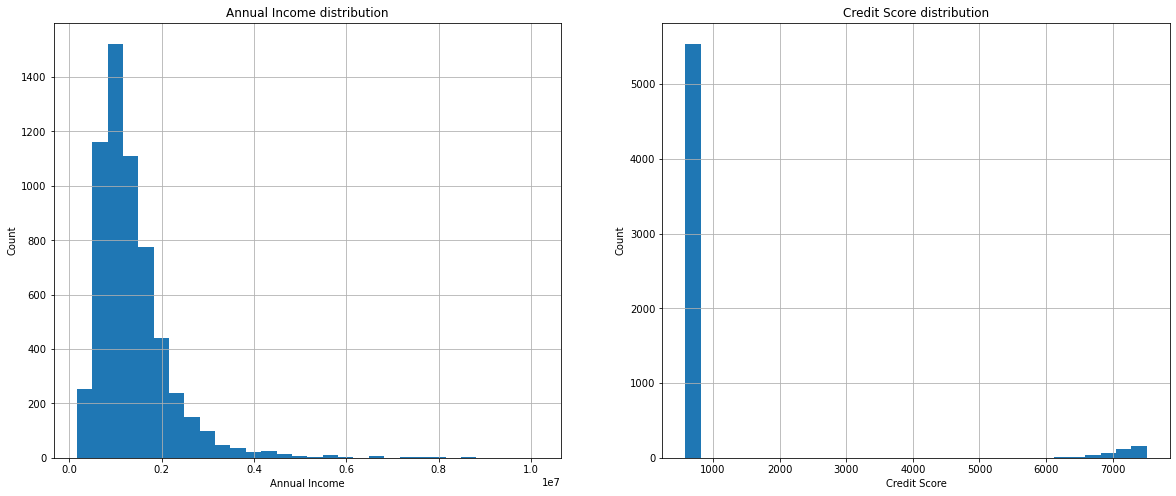

In [11]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
df['Annual Income'].hist(bins=30)

# plt.subplot(122)
ax1 = plt.subplot(122)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
df['Credit Score'].hist(bins=30)

plt.show()

In [12]:
df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].mode()[0]
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].mode()[0]

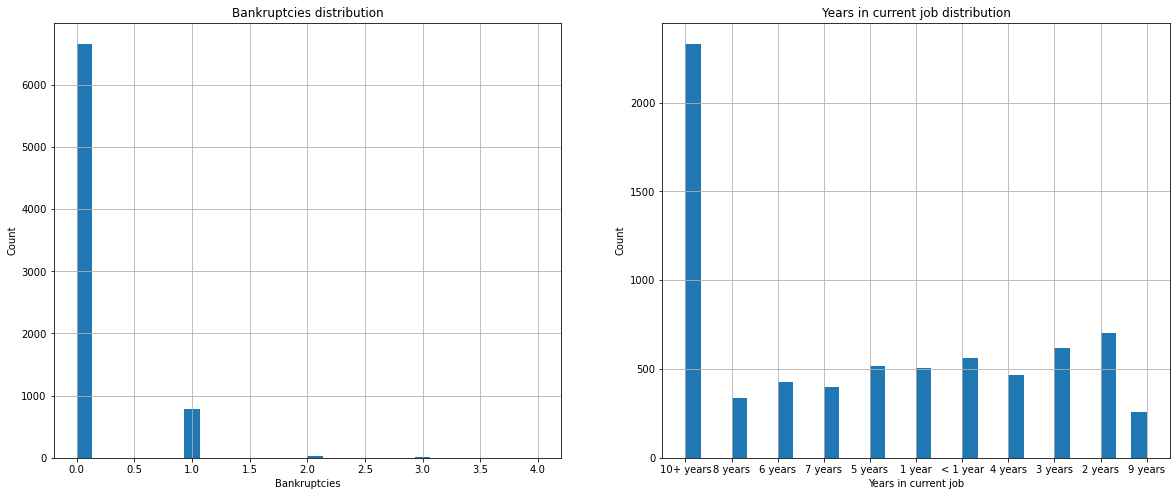

In [13]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Bankruptcies')
ax1.set_ylabel('Count')
ax1.set_title('Bankruptcies distribution')
df['Bankruptcies'].hist(bins=30)

# plt.subplot(122)
ax1 = plt.subplot(122)
ax1.set_xlabel('Years in current job')
ax1.set_ylabel('Count')
ax1.set_title('Years in current job distribution')
df['Years in current job'].hist(bins=30)

plt.show()

Признак **"Years in current job"** можно разбить на 4 категории: "< 1 year" == 0, "1-5 years" == 1, "5-6 years" == 2 и "10+ years" == 3. Так как я не экономист, точно не знаю, но интуитивно догадываюсь, что более долгий срок на одном рабочем месте повышает доверие.
Признак **"Bankruptcies"** можно разделить на 2 категории: не банкрот == 0 и банкрот == 1

In [14]:
# YearsInCurrentJob
df['Years_In_Current_Job_cat'] = df['Years in current job'].replace({'< 1 year':'0', 
                                                               '1 year':'1', '2 years':'1', '3 years':'1', '4 years':'1', '5 years':'1',
                                                               '6 years':'2', '7 years':'2', '8 years':'2', '9 years':'2', '10 years':'2',
                                                               '10+ years':'3'})
# Bankruptcies
df['Bankruptcies_cat'] = df['Bankruptcies'].replace({0:'0', 1:'1', 2:'1', 3:'1', 4:'1'})

Сейчас пропуски в данном признаке можно отнести к наиболее "модной" категории

In [15]:
df.loc[df['Years_In_Current_Job_cat'].isna(), 'Years_In_Current_Job_cat'] = df['Years_In_Current_Job_cat'].mode()[0]
df.loc[df['Bankruptcies_cat'].isna(), 'Bankruptcies_cat'] = df['Bankruptcies_cat'].mode()[0]

Самое большое число пропусков в признаке 'Months since last delinquent' = 4081. Полагаю, что данный признак очень важен для оценки надежности заемщика: чем дольше заемщик не возвращает кредит кредитору, тем ниже надежность. Могу предположить, что если данные отсутствуют, то заемщик возвращает кредит вовремя. 

In [16]:
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

### Обработка выбросов

**'CurrentLoanAmount'** = 99999999.0  выглядит как выброс. Заменим данное знечение на медиану.

In [17]:
median_current_loan_amount = df['Current Loan Amount'].median()
df.loc[(df['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

### Номинальные признаки

Признаки NumberOfOpenAccounts и NumberOfCreditProblems можно отнести к номинальным. 

In [18]:
df['Number of Open Accounts'] = (df['Number of Open Accounts']).astype(int)
df['Number of Credit Problems'] = (df['Number of Credit Problems']).astype(int)

Я без понятия влияют ли налоговые обременения на решение о выдачи кредита, и если да, то как. Поэтому просто отсавляю данный признак без всяких манимулякий над ним

### Категориальные признаки

In [19]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Среди других категориальных признаков, я полагаю, что домовладение может повлиять на надежность заемщика. Цель кредита будет, скорее всего коррелировать с суммой кредита и не будет сильно влиять на его выдачу. Срок кредитования, скорее всего, будет влиять на положительный / отрицательный ответ.

In [20]:
df.drop(['Years in current job', 'Bankruptcies', 'Purpose'], axis=1, inplace=True)

### Создание новых признаков

In [21]:
# HomeOwnership
df['Home_Ownership_cat'] = df['Home Ownership'].replace({'Home Mortgage':'0', 'Have Mortgage':'0', 'Rent':'1', 'Own Home':'2'})

In [22]:
for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

In [23]:
df.head()

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Term,Current Loan Amount,...,Term_Short Term,Years_In_Current_Job_cat_0,Years_In_Current_Job_cat_1,Years_In_Current_Job_cat_2,Years_In_Current_Job_cat_3,Bankruptcies_cat_0,Bankruptcies_cat_1,Home_Ownership_cat_0,Home_Ownership_cat_1,Home_Ownership_cat_2
0,Own Home,482087.0,0.0,11,26.3,685960.0,1,0.0,Short Term,309573.0,...,1,0,1,0,0,0,1,0,0,1
1,Own Home,1025487.0,0.0,15,15.3,1181730.0,0,0.0,Long Term,264968.0,...,0,0,0,0,1,1,0,0,0,1
2,Home Mortgage,751412.0,0.0,11,35.0,1182434.0,0,0.0,Short Term,309573.0,...,1,0,0,1,0,1,0,1,0,0
3,Own Home,805068.0,0.0,8,22.5,147400.0,1,0.0,Short Term,121396.0,...,1,0,0,1,0,0,1,0,0,1
4,Rent,776264.0,0.0,13,13.6,385836.0,1,0.0,Short Term,125840.0,...,1,0,0,1,0,1,0,0,1,0


In [24]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   int32  
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   int32  
 7   Months since last delinquent  7500 non-null   float64
 8   Term                          7500 non-null   object 
 9   Current Loan Amount           7500 non-null   float64
 10  Current Credit Balance        7500 non-null   float64
 11  Monthly Debt                  7500 non-null   float64
 12  Credit Score                  7500 non-null   float64
 13  Cre

Удалим столбцы с категориальными данными, из которых создали новые признаки

In [25]:
df.drop(['Home Ownership', 'Years_In_Current_Job_cat', 'Home_Ownership_cat', 'Bankruptcies_cat', 'Term'], axis=1, inplace=True)

In [26]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Tax Liens                     7500 non-null   float64
 2   Number of Open Accounts       7500 non-null   int32  
 3   Years of Credit History       7500 non-null   float64
 4   Maximum Open Credit           7500 non-null   float64
 5   Number of Credit Problems     7500 non-null   int32  
 6   Months since last delinquent  7500 non-null   float64
 7   Current Loan Amount           7500 non-null   float64
 8   Current Credit Balance        7500 non-null   float64
 9   Monthly Debt                  7500 non-null   float64
 10  Credit Score                  7500 non-null   float64
 11  Credit Default                7500 non-null   int64  
 12  Term_Long Term                7500 non-null   uint8  
 13  Ter

### Нормализация количесвенных переменных

In [27]:
from sklearn import preprocessing

In [28]:
col_feature_names = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [29]:
scaler = preprocessing.StandardScaler()

df_norm = df.copy()
df_norm[col_feature_names] = scaler.fit_transform(df_norm[col_feature_names])

df = df_norm.copy()

In [30]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [31]:
df.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Term_Short Term,Years_In_Current_Job_cat_0,Years_In_Current_Job_cat_1,Years_In_Current_Job_cat_2,Years_In_Current_Job_cat_3,Bankruptcies_cat_0,Bankruptcies_cat_1,Home_Ownership_cat_0,Home_Ownership_cat_1,Home_Ownership_cat_2
0,-1.042166,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,0.002830,-0.762772,-0.872085,...,1,0,1,0,0,0,1,0,0,1
1,-0.335956,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.257436,0.330781,0.004909,...,0,0,0,0,1,1,0,0,0,1
2,-0.692148,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,0.002830,0.058379,-0.391034,...,1,0,0,1,0,1,0,1,0,0
3,-0.622416,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,-1.095166,-0.610282,-0.584980,...,1,0,0,1,0,0,1,0,0,1
4,-0.659850,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-1.069235,-0.618292,-0.933631,...,1,0,0,1,0,1,0,0,1,0


### Разбиение датасета на тестовую и валидационную 

In [32]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve

In [33]:
target_name = 'Credit Default'

In [34]:
X = df.drop(columns=target_name)
y = df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

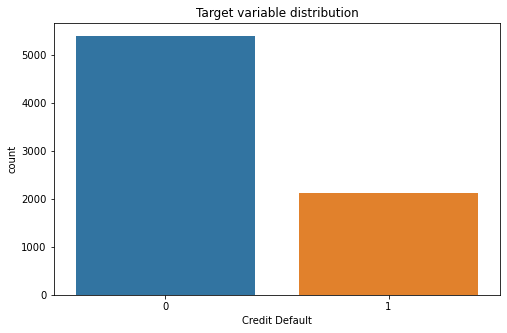

In [35]:
plt.figure(figsize=(8, 5))

sns.countplot(x=y, data=df)

plt.title('Target variable distribution')
plt.show()

In [36]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [37]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [38]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [39]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

### Сохранение обучающего и валидационного датасетов

In [40]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [41]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

## Обучение модели

Для начала я создала датасет со сниженной размерностью (PCA) с 3мя главными компонентами с самой большой объяснённой дисперсией. При этом сохранялось почти 98 процентов информации.
Обучение проводила как на изначальном датасете, так и на датасете со сниженной размерностью в сравнении. Для обучения использовала такие методы как: логистическая регрессия, _К_ ближайших соседей, деревья решений и случайный лес. F1-score и на тренировочном и на валидауионном датасетах были для 0 класса >0.8, а для 1 класса < 0.5. 
Бустинговые модели проявили себя лучше. При использовании **XGBoost** f1-score на тренировочном датасете для 0 класса составил 0,99, для 1 класса 0,98. На валидационном датасете f1-score для 0 класса составил 0,82, для 1 класса - 0,48.
Результаты **CatBoost** были более перспективными: f1-score на тренировочном датасете для 0 класса составил 0,92, для 1 класса 0,90, но на валидационном датасете 0,83 - для 0 класса и 0,50 - для 1 класса.
Результаты **LightGBM** незначительно отличались от результатов **CatBoost**: f1-score на тренировочном датасете для 0 класса составил 0,93, для 1 класса 0,91; на валидационном датасете 0,82 - для 0 класса и 0,50 - для 1 класса.
Далее я снова провела обработку данных, обучила тренировочную выборку и оценила на влидационной с использрванием моделей описанных выше. Лучшие показатели были у модели **CatBoost** с параметрами: n_estimators=500, max_depth=3. Только данная модель представленна в курсовом проекте.

#### Обучение и оценка финальной модели

In [42]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [43]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3771
           1       0.80      0.63      0.70      2958

    accuracy                           0.77      6729
   macro avg       0.77      0.75      0.76      6729
weighted avg       0.77      0.77      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1616
           1       0.54      0.49      0.51       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1351  265
1                324  310
Wall time: 3.09 s


### Подготовка тестового датасета

In [44]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [45]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [46]:
# Добавляется признак has_delay, всем наблюдениям присваивается 1
# df_test['has_delay'] = 1

# Пропуски и выбросы
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Annual Income'].mode()[0]
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = df_test['Credit Score'].mode()[0]
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = df_test['Years in current job'].mode()[0]
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [47]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [48]:
df_test['Number of Open Accounts'] = (df_test['Number of Open Accounts']).astype(int)
df_test['Number of Credit Problems'] = (df_test['Number of Credit Problems']).astype(int)

In [49]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   int32  
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int32  
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [50]:
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

In [51]:
df_test['Years_In_Current_Job_cat'] = df_test['Years in current job'].replace({'< 1 year':'0', '1 year':'1', '2 years':'1', 
                                                                               '3 years':'1', '4 years':'1', '5 years':'1',
                                                                               '6 years':'2', '7 years':'2', '8 years':'2',
                                                                               '9 years':'2', '10 years':'2', '10+ years':'3'})
df_test['Bankruptcies_cat'] = df_test['Bankruptcies'].replace({0:'0', 1:'1', 2:'1', 3:'1', 4:'1'})
df_test['Home_Ownership_cat'] = df_test['Home Ownership'].replace({'Home Mortgage':'0', 'Have Mortgage':'0', 'Rent':'1', 'Own Home':'2'})

In [52]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   int32  
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int32  
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [53]:
df_test.drop(['Home Ownership', 'Years in current job', 'Bankruptcies'], axis=1, inplace=True)

In [54]:
for cat_colname in df_test.select_dtypes(include='object').columns[1:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [55]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   int32  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   int32  
 6   Months since last delinquent  2500 non-null   float64
 7   Purpose                       2500 non-null   object 
 8   Term                          2500 non-null   object 
 9   Current Loan Amount           2500 non-null   float64
 10  Current Credit Balance        2500 non-null   float64
 11  Monthly Debt                  2500 non-null   float64
 12  Credit Score                  2500 non-null   float64
 13  Yea

In [56]:
df_test.drop(['Years_In_Current_Job_cat', 'Home_Ownership_cat', 'Bankruptcies_cat', 'Term', 'Purpose'], axis=1, inplace=True)

In [57]:
from sklearn import preprocessing

In [58]:
col_feature_names = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [59]:
scaler = preprocessing.StandardScaler()

df_norm_test = df_test.copy()
df_norm_test[col_feature_names] = scaler.fit_transform(df_norm_test[col_feature_names])

df_test = df_norm_test.copy()

In [60]:
df_test.to_csv(PREP_TEST, index=False, encoding='utf-8')

In [61]:
df_test.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Years_In_Current_Job_cat_0,Years_In_Current_Job_cat_1,Years_In_Current_Job_cat_2,Years_In_Current_Job_cat_3,Bankruptcies_cat_5.0,Bankruptcies_cat_0,Bankruptcies_cat_1,Home_Ownership_cat_0,Home_Ownership_cat_1,Home_Ownership_cat_2
0,-0.327678,-0.091141,-0.450224,-0.803220,-0.323879,-0.289398,2.405202,-0.883841,-0.503642,-0.992788,...,0,1,0,0,0,1,0,0,1,0
1,-1.284626,-0.091141,-1.068551,1.981755,-0.433044,-0.289398,-0.336726,-1.374743,-0.661931,-1.382250,...,0,1,0,0,0,1,0,0,1,0
2,-0.174004,-0.091141,-0.244115,-0.637776,-0.334707,-0.289398,-0.690524,-0.663923,-0.396341,0.039653,...,0,1,0,0,0,1,0,1,0,0
3,-0.092251,-0.091141,0.992538,-0.182805,-0.168202,-0.289398,2.405202,-0.563587,-0.219968,0.804714,...,0,0,0,1,0,1,0,1,0,0
4,1.259550,-0.091141,-0.038006,0.727138,0.328576,-0.289398,-0.690524,2.703877,0.341051,2.108349,...,0,0,1,0,0,1,0,1,0,0


In [62]:
y_pred_output = final_model.predict(df_test)

In [64]:
y_pred_output.shape

(2500,)

In [65]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [66]:
result.to_csv(PREP_TEST, index=False)